In [72]:
# Using pymc v4
import numpy as np
import pymc as pm
import aesara
import aesara.tensor as at
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

In [2]:
#This functions generate data corresponding to two outputs
f_output1 = lambda x: 4. * np.cos(x/5.) - .4*x - 35. + np.random.rand(x.size)[:,None] * 2.
f_output2 = lambda x: 6. * np.cos(x/5.) + .2*x + 35. + np.random.rand(x.size)[:,None] * 8.


#{X,Y} training set for each output
X1 = np.random.rand(100)[:,None]; X1=X1*75
X2 = np.random.rand(100)[:,None]; X2=X2*70 + 30
Y1 = f_output1(X1)
Y2 = f_output2(X2)
#{X,Y} test set for each output
Xt1 = np.random.rand(100)[:,None]*100
Xt2 = np.random.rand(100)[:,None]*100
Yt1 = f_output1(Xt1)
Yt2 = f_output2(Xt2)

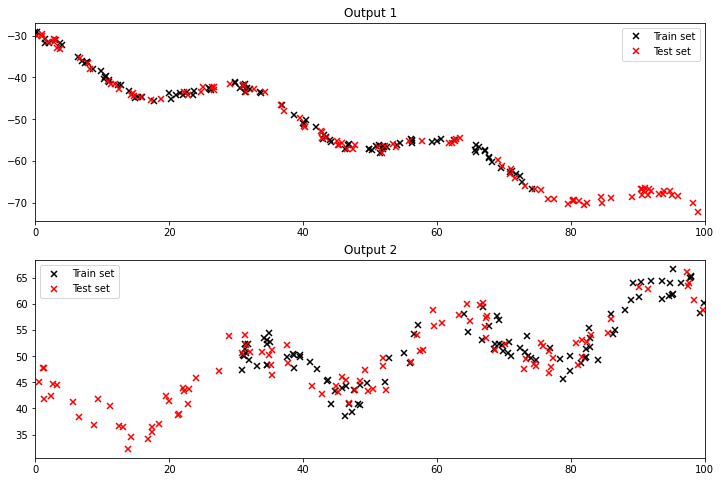

In [3]:
xlim = (0,100); ylim = (0,50)
fig, ax = plt.subplots(2, figsize=(12,8))
# ax[0] = fig.add_subplot(211)
ax[0].set_xlim(xlim)
ax[0].set_title('Output 1')
ax[0].plot(X1[:,:1],Y1,'kx',mew=1.5,label='Train set')
ax[0].plot(Xt1[:,:1],Yt1,'rx',mew=1.5,label='Test set')
ax[0].legend()
# ax2 = fig.add_subplot(212)
ax[1].set_xlim(xlim)
ax[1].set_title('Output 2')
ax[1].plot(X2[:,:1],Y2,'kx',mew=1.5,label='Train set')
ax[1].plot(Xt2[:,:1],Yt2,'rx',mew=1.5,label='Test set')
ax[1].legend()
plt.show()

In [4]:
X = np.concatenate((X1, X2), axis=0)
idx = np.concatenate((np.zeros(len(X1)), np.ones(len(X2))))[:, None]
X = np.concatenate((X, idx), axis=1)
X1.shape, X2.shape, X.shape

((100, 1), (100, 1), (200, 2))

In [5]:
y = np.concatenate((Y1, Y2)).squeeze()
Y1.shape, Y2.shape, y.shape

((100, 1), (100, 1), (200,))

In [13]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

/tmp/ipykernel_29523/46575181.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))


In [14]:
with model:
    mp = pm.find_MAP()

### Test

In [15]:
Xt = np.concatenate((Xt1, Xt2), axis=0)
idx = np.concatenate((np.zeros(len(Xt1)), np.ones(len(Xt2))))[:, None]
Xt = np.concatenate((Xt, idx), axis=1)
Xt1.shape, Xt2.shape, Xt.shape

((100, 1), (100, 1), (200, 2))

In [16]:
with model:
    f_pred = gp.conditional("f_pred", Xt)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], var_names=['f_pred'])

In [18]:
pred_samples

Inference data with groups:
	> posterior_predictive
	> observed_data

In [37]:
pred_samples.posterior_predictive["f_pred"].squeeze().shape

(200,)

In [41]:
f_pred[:100].shape

(100,)

In [42]:
Xt[:100,0].shape

(100,)

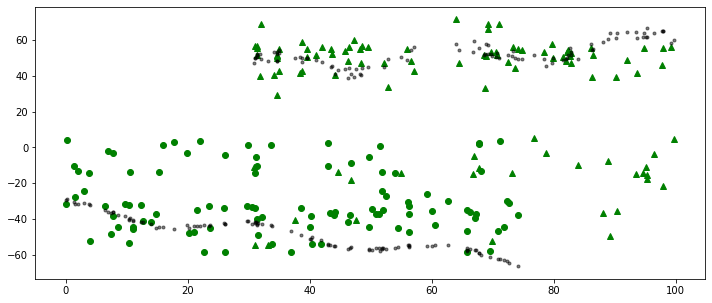

In [48]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = pred_samples.posterior_predictive["f_pred"].squeeze()
#plot_gp_dist(ax, f_pred[:100], Xt[:100,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
#plot_gp_dist(ax, f_pred[100:], Xt[100:,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(X1, f_pred[:100], "og", lw=3, label="Pred f1");
ax.plot(X2, f_pred[100:], "^g", lw=3, label="Pred f2");
# ax.plot(X1, f1, "green", lw=3, label="True f1");
# ax.plot(X2, f2, "tomato", lw=3, label="True f2");

ax.plot(X1, Y1, 'ok', ms=3, alpha=0.5, label="Data 1");
ax.plot(X2, Y2, 'ok', ms=3, alpha=0.5, label="Data 2");

In [49]:
def build_XY(input_list,output_list=None,index=None):
    num_outputs = len(input_list)
    if output_list is not None:
        assert num_outputs == len(output_list)
        Y = np.vstack(output_list)
    else:
        Y = None

    if index is not None:
        assert len(index) == num_outputs
        I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,index)] )
    else:
        I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )

    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])

    return X,Y,I[:,None]#slices

In [50]:
xb, yb, idx = build_XY([X1, X2], [Y1, Y2])
xb.shape, yb.shape, idx.shape

((200, 2), (200, 1), (200, 1))

In [65]:
from aesara.tensor.slinalg import kron
from aesara.tensor.type import dmatrix, matrix, tensor, vector

In [88]:
from aesara.graph.basic import Variable
from aesara.tensor.sharedvar import TensorSharedVariable
from aesara.tensor.var import TensorConstant

In [99]:
def square_dist(X, Xs, ls=1):
    X = at.mul(X, 1.0 / ls)
    X2 = at.sum(at.square(X), 1)
    if Xs is None:
        sqd = -2.0 * at.dot(X, at.transpose(X)) + (
            at.reshape(X2, (-1, 1)) + at.reshape(X2, (1, -1))
        )
    else:
        Xs = at.mul(Xs, 1.0 / self.ls)
        Xs2 = at.sum(at.square(Xs), 1)
        sqd = -2.0 * at.dot(X, at.transpose(Xs)) + (
            at.reshape(X2, (-1, 1)) + at.reshape(Xs2, (1, -1))
        )
    return at.clip(sqd, 0.0, np.inf)

In [100]:
def ExpQuad(X, Xs=None):
    X, Xs = _slice(X, Xs)
    return at.exp(-0.5 * square_dist(X, Xs))

In [101]:
def _slice(X, Xs):
    
    xdims = X.shape[-1]
    active_dims = np.arange(xdims)
    if isinstance(xdims, Variable):
        xdims = xdims.eval()
    X = at.as_tensor_variable(X[:, active_dims])
    if Xs is not None:
        Xs = at.as_tensor_variable(Xs[:, active_dims])
    return X, Xs

In [102]:
X = np.linspace(0, 2, 200)[:, None]
K = ExpQuad(X)

In [107]:
K.shape.eval(), X.shape

(array([200, 200]), (200, 1))

In [112]:
X = np.concatenate((X1, X2), axis=0)
idx = np.concatenate((np.zeros(len(X1)), np.ones(len(X2))))[:, None]
X = np.concatenate((X, idx), axis=1)
X1.shape, X2.shape, X.shape

((100, 1), (100, 1), (200, 2))

In [120]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    #cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    K = eta**2 * ExpQuad(X)
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    B = at.dot(W, W.T) + at.diag(kappa)
    cov_func = cov
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

/tmp/ipykernel_29523/1082714626.py:7: FutureWarning: The `testval` argument is deprecated; use `initval`.
  W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))


In [121]:
with model:
    pm.sample()

ValueError: Invalid dimension for value: 4

In [117]:
B.shape.eval(), K.shape.eval()

(array([2, 2]), array([200, 200]))

In [118]:
f = aesara.function([B, K], kron(B, K))
bk = f(B, K)

TypeError: Bad input argument to aesara function with name "/tmp/ipykernel_29523/2130488170.py:1" at index 0 (0-based).  
Backtrace when that variable is created:

  File "/home/danph/.pyenv/versions/miniconda3-4.7.10/envs/pymc-dev-py39/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/danph/.pyenv/versions/miniconda3-4.7.10/envs/pymc-dev-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
    result = self._run_cell(
  File "/home/danph/.pyenv/versions/miniconda3-4.7.10/envs/pymc-dev-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2900, in _run_cell
    return runner(coro)
  File "/home/danph/.pyenv/versions/miniconda3-4.7.10/envs/pymc-dev-py39/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/danph/.pyenv/versions/miniconda3-4.7.10/envs/pymc-dev-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/danph/.pyenv/versions/miniconda3-4.7.10/envs/pymc-dev-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3301, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/danph/.pyenv/versions/miniconda3-4.7.10/envs/pymc-dev-py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_29523/1082714626.py", line 10, in <cell line: 1>
    B = at.dot(W, W.T) + at.diag(kappa)
Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?

In [115]:
K

Elemwise{mul,no_inplace}.0

In [114]:
K.shape.eval(), X.shape

(array([200, 200]), (200, 2))

In [81]:
cov.

In [119]:
type(x), type(y)

(aesara.tensor.var.TensorVariable, aesara.tensor.var.TensorVariable)

In [77]:
for shp0 in [(2,), (2, 3), (2, 3, 4), (2, 3, 4, 5)]:
    x = tensor(dtype="floatX", shape=(False,) * len(shp0))
    a = np.asarray(np.random.random(shp0)).astype(aesara.config.floatX)
    for shp1 in [(6,), (6, 7), (6, 7, 8), (6, 7, 8, 9)]:
        if len(shp0) + len(shp1) == 2:
            continue
        y = tensor(dtype="floatX", shape=(False,) * len(shp1))
        f = aesara.function([x, y], kron(x, y))
        b = np.random.random(shp1).astype(aesara.config.floatX)
        out = f(a, b)
        print(a.shape, b.shape, out.shape)

(2,) (6, 7) (84,)
(2,) (6, 7, 8) (14, 48)
(2,) (6, 7, 8, 9) (14, 48, 9)
(2, 3) (6,) (36,)
(2, 3) (6, 7) (12, 21)
(2, 3) (6, 7, 8) (12, 21, 8)
(2, 3) (6, 7, 8, 9) (12, 21, 8, 9)
(2, 3, 4) (6,) (8, 18)
(2, 3, 4) (6, 7) (8, 18, 7)
(2, 3, 4) (6, 7, 8) (8, 18, 7, 8)
(2, 3, 4) (6, 7, 8, 9) (8, 18, 7, 8, 9)
(2, 3, 4, 5) (6,) (8, 15, 6)
(2, 3, 4, 5) (6, 7) (8, 15, 6, 7)
(2, 3, 4, 5) (6, 7, 8) (8, 15, 6, 7, 8)
(2, 3, 4, 5) (6, 7, 8, 9) (8, 15, 6, 7, 8, 9)
